## Preparing data

### Setting up the environment

```bash
conda create -n bulk -c conda-forge -c bioconda -c defaults star subread python=3.8 bioconductor-deseq2 bioconductor-apeglm rpy2 -y

conda activate bulk
pip install git+https://github.com/LouisFaure/deseq2py.git
pip install git+https://github.com/LouisFaure/bulktools-py.git
```

### Downloading genome and annotation
```bash
wget https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M27/gencode.vM27.annotation.gtf.gz
wget https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M28/GRCm39.primary_assembly.genome.fa.gz
gunzip *.gz
```

### Making STAR reference genome
```bash
STAR --runMode genomeGenerate --runThreadN 40 --genomeDir GRCm39_vM27_ML --genomeFastaFiles GRCm39.primary_assembly.genome.fa --sjdbGTFfile gencode.vM27.annotation.gtf --sjdbOverhang 50

```


### Do the counting

```bash
bt -s GRCm39_vM27_ML -g gencode.vM27.annotation.gtf -n 20
```

## Perform the analysis

### Load libraries

In [1]:
import os, sys
os.environ['R_HOME'] = sys.exec_prefix+"/lib/R/"
import scanpy as sc
import numpy as np
import pandas as pd
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["font.family"] = ["sans-serif"]
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["savefig.bbox"] = "tight"
sc.set_figure_params()


### Load and prepare count data

In [2]:
adata_bulk=sc.read("adata_bulk_star.h5ad")
adata_bulk.obs["exp"]=adata_bulk.obs_names
adata_bulk.obs["condition"]=[''.join([i for i in s if not i.isdigit()]) for s in adata_bulk.obs_names]
adata_bulk.obs["condition"]=adata_bulk.obs["condition"].astype("category")


In [3]:
adata_bulk.obs["condition"]=adata_bulk.obs["condition"].cat.reorder_categories(["M","CC"])

In [4]:
adata_bulk.obs.condition=adata_bulk.obs.condition.cat.rename_categories(["Mutant","Control"])

### Running DESeq2 pipeline

In [5]:
import deseq2py as deseq2

In [6]:
deseq2.tl.run(adata_bulk,formula="~ condition")

Running DESeq2
    done (0:00:07) --> added
    .layers['normalized'] normalized count matrix.
    .uns['dds'] DESeq2 R object.
    .uns['Formula'] formula used for design parameter.


### Performing PCA

In [7]:
deseq2.tl.vst(adata_bulk)

Obtaining vsd
    done (0:00:00) --> added
    .layers['vsd'] variance stabilized count matrix.


In [8]:
deseq2.tl.pca(adata_bulk)

Obtaining PCA
    on highly variable genes using vsd matrix
    done (0:00:00) --> added
    .var['vsd_std'] variance of genes calculated from vsd matrix.
    .var['highly_variable'] genes considered as highly variable.
    .obsm['X_pca'] PCA results.
    .uns['pca'] PCA additional results.


/data1/soldatr/louis/miniforge3/envs/bulk/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


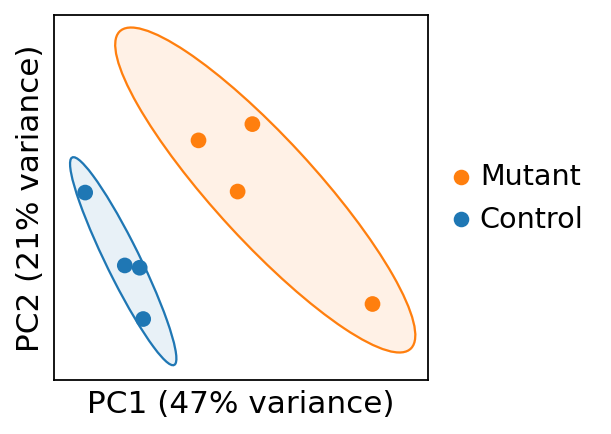

In [9]:
fig, ax = plt.subplots(figsize=(3,3))
deseq2.pl.pca(adata_bulk,color="condition",title="",palette=["tab:orange","tab:blue"],
              show_ellipses=True,ellipse_std=2,show=False,ax=ax)
plt.savefig("PCA.svg",dpi=600)

In [10]:
deseq2.tl.result(adata_bulk,lfc_shrink=True,name="condition_Control_vs_Mutant")

Generating DE results
    running LFC shrinking
    done (0:00:05) --> added
    .uns['condition_Control_vs_Mutant']['LFC_shrink'] table of differential expression results.


In [11]:
adata_bulk.uns['condition_Control_vs_Mutant']['LFC_shrink'].sort_values("padj")

,baseMean,log2FoldChange,lfcSE,pvalue,padj
Geneid,,,,,
Pbx1,9676.891394,2.150542,0.076259,2.025943e-176,3.072950e-172
Col6a4,199.669405,2.079027,0.167194,1.017102e-36,7.713700e-33
Rgs2,1592.976437,-0.891190,0.077315,5.065134e-32,2.560932e-28
Hapln1,4004.107885,-1.550199,0.136020,2.123991e-31,8.054173e-28
Lgi2,2702.452794,0.815095,0.072041,6.017088e-31,1.825344e-27
...,...,...,...,...,...
mt-Nd4l,0.000000,NaN,NaN,NaN,NaN
mt-Th,0.000000,NaN,NaN,NaN,NaN
mt-Ts2,0.807339,0.002425,0.083364,4.800621e-01,NaN


In [12]:
adata_bulk.uns['condition_Control_vs_Mutant']['LFC_shrink'].loc[["Pbx1","Cdkn2a","Cdkn2b","Gadd45g","Cdkn1c","Cdkn1b"]]

,baseMean,log2FoldChange,lfcSE,pvalue,padj
Geneid,,,,,
Pbx1,9676.891394,2.150542,0.076259,2.025943e-176,3.072950e-172
Cdkn2a,68.362763,1.204040,0.284557,9.626882e-07,1.196890e-04
Cdkn2b,236.185480,0.978425,0.159272,3.869016e-11,1.504749e-08
Gadd45g,5960.908155,0.425078,0.063192,1.149246e-12,6.737796e-10
Cdkn1c,11621.337775,0.338712,0.101817,4.524688e-05,2.691391e-03
Cdkn1b,3823.366063,0.173405,0.064620,1.150376e-03,2.877855e-02


In [13]:
adata_bulk.layers["scaled"]=sc.pp.scale(adata_bulk.layers["normalized"],copy=True)

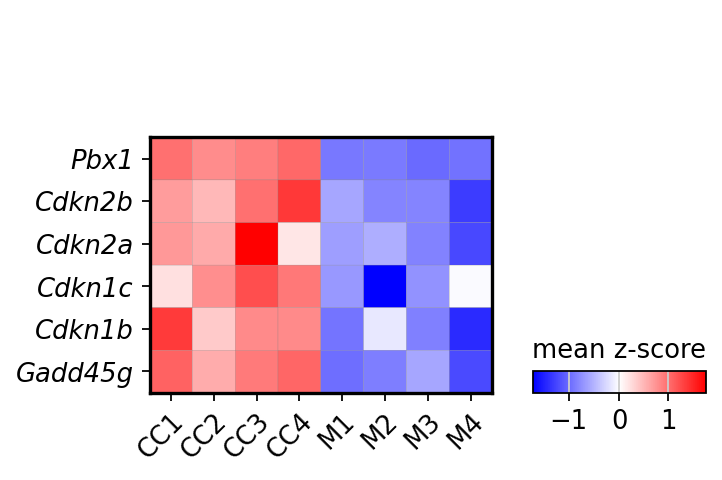

In [14]:

genes=["Pbx1","Cdkn2b","Cdkn2a","Cdkn1c","Cdkn1b","Gadd45g"]
ax=sc.pl.matrixplot(adata_bulk,genes,groupby="exp",layer="scaled",vcenter=0,show=False,
                 cmap="bwr",colorbar_title="mean z-score",swap_axes=True)

plt.setp(ax['mainplot_ax'].get_yticklabels(),style="italic");
plt.setp(ax['mainplot_ax'].get_xticklabels(),rotation=45,
         rotation_mode="anchor",ha="right");
plt.savefig("bulk_matrixplot.pdf")

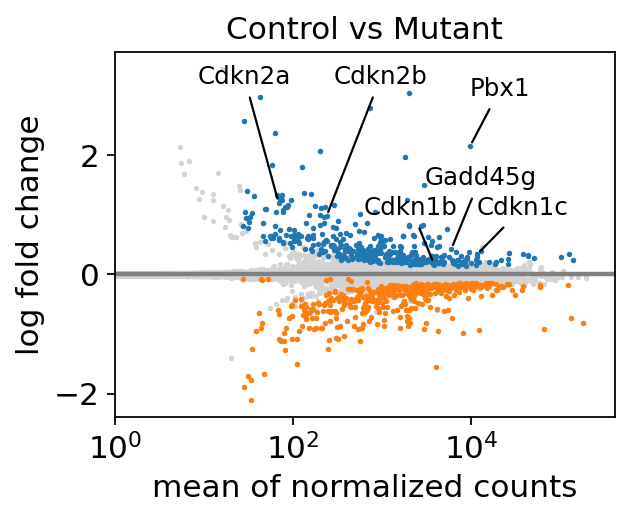

In [51]:
from adjustText import adjust_text
fig, ax = plt.subplots(figsize=(4,3))


df=adata_bulk.uns["condition_Control_vs_Mutant"]["LFC_shrink"]
if ax is None:
    fig,ax=plt.subplots(figsize=figsize,constrained_layout=True)
ax.scatter(df.baseMean,df.log2FoldChange,
           s=2,c="lightgrey",rasterized=True)

cond1=(df.padj<0.05) & (df.log2FoldChange>0)
cond2=(df.padj<0.05) & (df.log2FoldChange<0)

ax.scatter(df.loc[cond1].baseMean,df.loc[cond1].log2FoldChange,
           s=2,rasterized=True)

ax.scatter(df.loc[cond2].baseMean,df.loc[cond2].log2FoldChange,
           s=2,rasterized=True)
ax.semilogx();
ax.set_ylabel("log fold change");
ax.set_xlabel("mean of normalized counts");
ax.axhline(c="grey",linewidth=2)
ax.grid(False)

ax.set_title("Control vs Mutant")
ax.set_xlim(left=1)

ax.annotate(genes[0],
            xy = (df.loc[genes[0]].baseMean,df.loc[genes[0]].log2FoldChange),
            xytext = (df.loc[genes[0]].baseMean,3),
           arrowprops = dict(
    arrowstyle="-"),fontsize=11)

ax.annotate(genes[1],
            xy = (df.loc[genes[1]].baseMean,df.loc[genes[1]].log2FoldChange),
            xytext = (df.loc[genes[1]].baseMean+50,3.2),
           arrowprops = dict(
    arrowstyle="-"),fontsize=11)

ax.annotate(genes[2],
            xy = (df.loc[genes[2]].baseMean,df.loc[genes[2]].log2FoldChange),
            xytext = (df.loc[genes[2]].baseMean-60,3.2),
           arrowprops = dict(
    arrowstyle="-"),fontsize=11)


ax.annotate(genes[3],
            xy = (df.loc[genes[3]].baseMean,df.loc[genes[3]].log2FoldChange),
            xytext = (df.loc[genes[3]].baseMean-50,1),
           arrowprops = dict(
    arrowstyle="-"),fontsize=11)


ax.annotate(genes[4],
            xy = (df.loc[genes[4]].baseMean,df.loc[genes[4]].log2FoldChange),
            xytext = (df.loc[genes[4]].baseMean-3200,1),
           arrowprops = dict(
    arrowstyle="-"),fontsize=11)


ax.annotate(genes[5],
            xy = (df.loc[genes[5]].baseMean,df.loc[genes[5]].log2FoldChange),
            xytext = (df.loc[genes[5]].baseMean-3000,1.5),
           arrowprops = dict(
    arrowstyle="-"),fontsize=11)

plt.savefig("DESEQ2.pdf")

In [ ]:
import ad

## Save the results

In [17]:
deseq2.tl.save(adata_bulk,"adata_deseq2")

Saving results
    done --> saved
    adata_deseq2.h5ad: anndata file containing counts matrices, pca and DE results.
    adata_deseq2.rds: R object of the DESeqDataSet.


In [18]:
adata_bulk

AnnData object with n_obs × n_vars = 8 × 53762
    obs: 'exp', 'condition'
    var: 'vsd_std', 'highly_variable'
    uns: 'Formula', 'pca', 'condition_colors', 'condition_Control_vs_Mutant'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'normalized', 'vsd', 'scaled'

In [19]:
adata_bulk.uns['condition_Control_vs_Mutant']["LFC_shrink"].to_csv("DESEQ2.csv")